In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *

# Enforcing the speed limit replication notebook

In [2]:
NRUNS = 1

In [3]:
parameters = {
    # global parameters
    "n_lft": 20,
    "n_hft": 20,
    "ticks": 390, # 390 ticks per day
    "fundamental_value": 100,
    "lft_sample_size": 0.1,
    "hft_sample_size": 0.1,
    "std_noise": 0.01,
    "std_LFT_price": 0.01,
    "std_LFT_vol": 4,
    "std_HFT_vol": 4,
    "return_on_investment": 0.5,
    "investment_frequency": 5000,
    "max_order_expiration_ticks": 30,
    # lft parameters
    "w_fundamentalists": 3.5, #1
    "w_chartists": 1.6, # 10
    "w_random": 2.0,
    "spread_max": 0.004087,  # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "investment_fraction": 0.00,
    "hfm_risk_aversion": 25,
    "hfm_fixed_vol": 1,
    # initial values
    "wealth": 300,
    "horizon_min": 1,
    "horizon_max": 4,
    "av_return_interval_max": 4,
    "init_price": 1,
    "agent_order_price_variability": (1, 1),
    "total_hft_money": 2000,
    "hft_speed": 1,
    "hft_init_investment": 0
}

# Initialisation

In [4]:
# 1 initalise model objects
high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)

# Simulation

In [5]:
#%%timeit
for seed in range(NRUNS):
    high_frequency_traders, low_frequency_traders, orderbook = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)

120.51005663
120.51005663
120.51105663
95.159848762
95.159848762
95.160848762
93.6843740296
124.534097807
124.535097807
124.535097807
124.533097807
124.534097807
124.533097807
124.532097807
161.681399582
172.648781612
172.649781612
126.410830088
131.241994043
129.775409802
129.53319709
135.323424755
124.610779733
124.825230711
136.592358493
140.082155666
155.262471016
128.806536206
128.807536206
185.672174127
-18.9036480295
113.5847965
109.372501803
108.267136576
99.8875323901
122.843652389
105.708391325
105.709391325
142.667197565
37.3349064735
137.223438864
37.3339064735
137.221438864
129.031629927
-14.769591217
6.32563520693
130.671162695
96.5762782454
4.80874237851
3.03072804723
-5.57402168304
-58.5186276738
96.9946765108
-30.9049298368
96.9946765108
-11.5518493336
-38.9144290862
-38.9144290862
79.5425137298
-43.3011386588
-38.9144290862
7.72944281464
-24.1725449383
0.568013113013
110.545662144
28.3848401015
126.695849879
57.2681569541
11.4267888235
11.4267888235
2.57420184095
11.6

# Data analysis

In [6]:
end_tick_price = orderbook.tick_close_price #[np.mean(prices) for prices in orderbook.transaction_prices_history]
total_tick_volume = [sum(volumes) for volumes in orderbook.transaction_volumes_history]
returns = pd.Series(np.array(end_tick_price)).pct_change()
autocorr_returns = [pd.Series(returns).autocorr(lag=lag) for lag in range(25)]
absolute_returns = pd.Series(returns).abs()
autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]

## Prices, returns & volume

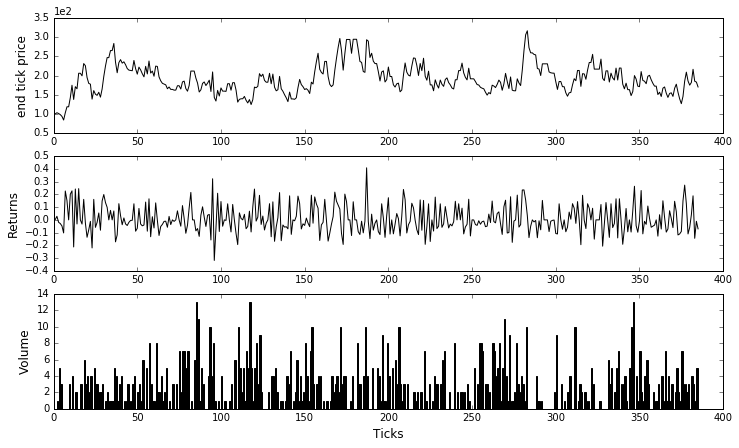

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,7))

ax1.plot(range(len(end_tick_price)), end_tick_price, 'k-')
ax1.set_ylabel('end tick price', fontsize='12')

ax2.plot(range(len(returns)), returns, 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(range(len(total_tick_volume)), total_tick_volume, color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

for ax in [ax1, ax2, ax3]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
#fig.savefig('hfm_dynamics.png')

## Bid-ask spread & volatility

In [9]:
bid_ask = bid_ask = [(ask - bid / np.mean(ask - bid)) / 2 for bid, ask in zip(orderbook.highest_bid_price_history, orderbook.lowest_ask_price_history)]
bid_ask = list(filter(lambda x: x >0, bid_ask))
# quoted bid_ask_spread = (Ask - Bid / Mid)
np.mean(bid_ask)

64.473202834472161

In [10]:
# is this the correct way 
window = 10
roller_returns = returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)
returns.std()

0.10728094058041031

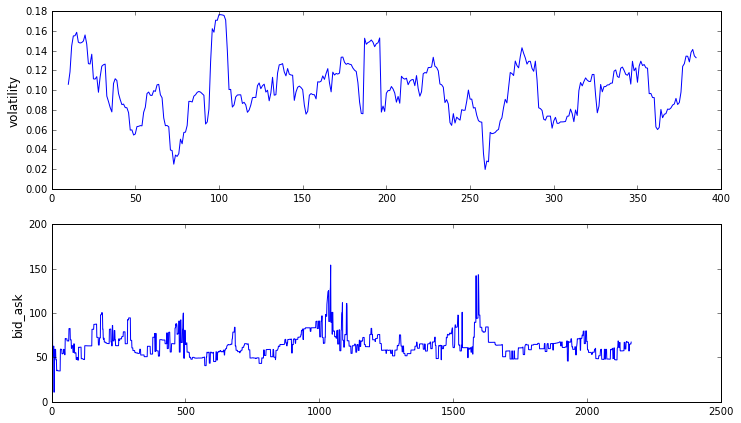

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,7))

ax1.plot(range(len(returns_volatility)), returns_volatility)
ax1.set_ylabel('volatility', fontsize='12')

ax2.plot(range(len(bid_ask)), bid_ask)
ax2.set_ylim(0, 200)
ax2.set_ylabel('bid_ask', fontsize='12')

# Basic financial market stylized facts
## No autocorrelation in returns

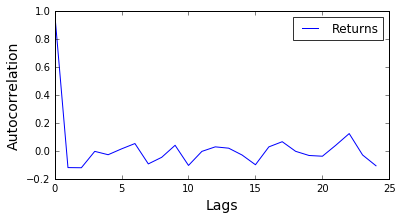

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(6,3))

ax1.plot(range(len(autocorr_returns)), autocorr_returns, label='Returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
#fig.savefig('auto_correlation.png')

## Excess Kurtosis

In [15]:
pd.Series(returns).kurtosis()

0.13878996393678111

## Clustered volatility

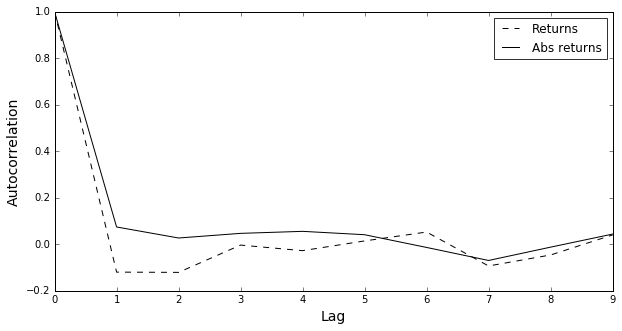

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 10

ax1.plot(range(len(autocorr_returns[:lenght])), autocorr_returns[:lenght], 'k--', label='Returns')
ax1.plot(range(len(autocorr_abs_returns[:lenght])), autocorr_abs_returns[:lenght], 'k-', label='Abs returns')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

#fig.savefig('auto_correlations.png')

# % of trades by HFT

In [17]:
def hft_in_match(match):
    for buy_sell in match:
        if 'HFT' in str(buy_sell):
            return True
    return False

In [18]:
amount_matched_orders = 0
hft_participating_orders = 0 
for tick in orderbook.matched_bids_history:
    amount_matched_orders += len(tick)
    for match in tick:
        if hft_in_match(match):
            hft_participating_orders += 1
        
print('total matches ', amount_matched_orders)
print('total hft matches ', hft_participating_orders)
print('percentage hft matches = ', hft_participating_orders / amount_matched_orders)

total matches  864
total hft matches  320
percentage hft matches =  0.37037037037037035


# HFT Investment

In [19]:
cum_inv = []
for hft in high_frequency_traders:
    cum_inv.append(np.array(hft.var_previous.cum_investment))

In [20]:
agg_cum_inv = np.zeros(len(cum_inv[0]))
for c_i in cum_inv:
    agg_cum_inv += c_i

C:\Users\p267237\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2767: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


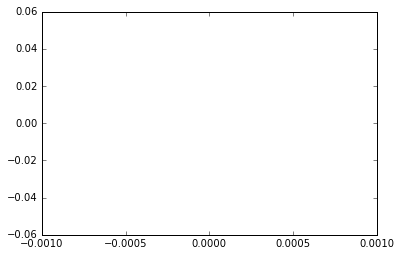

In [21]:
pd.Series(agg_cum_inv)[:100].plot()

# HFT speed

In [22]:
speed = []
for hft in high_frequency_traders:
    speed.append(np.array(hft.var_previous.speed))

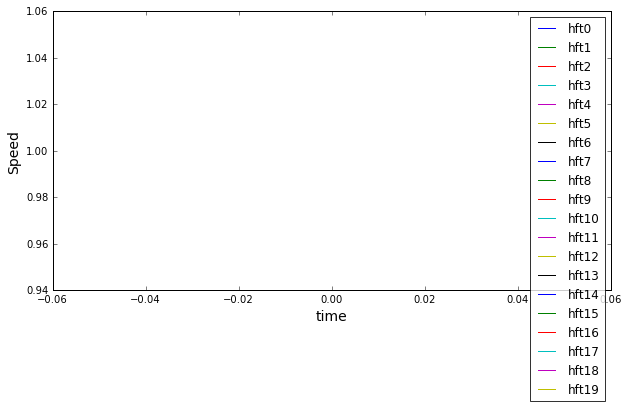

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, s in enumerate(speed):
    ax1.plot(range(len(s[:100])), s[:100], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Speed', fontsize='14')
ax1.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# HFT profitability

Total wealth. The HFT's track their own total wealth

In [24]:
money = []
stocks = []
locked_in_profits = []
for hft in high_frequency_traders:
    money.append(np.array(hft.var_previous.money))
    stocks.append(np.array(hft.var_previous.stocks))
    locked_in_profits.append(np.array(hft.var_previous.locked_profit))

### Locked in profits

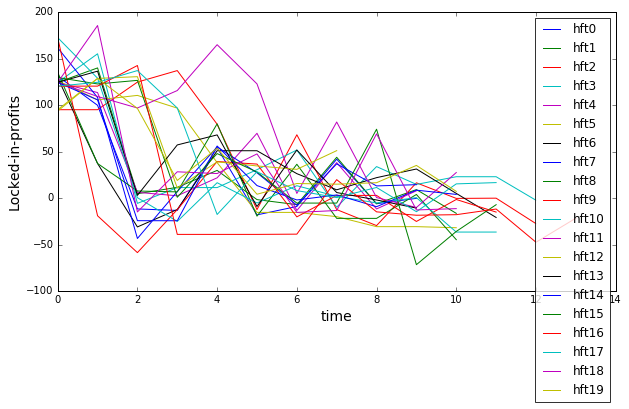

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

for idx, p in enumerate(locked_in_profits):
    ax1.plot(range(len(p)), p, label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Locked-in-profits', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

In [26]:
sum(locked_in_profits[0])

269.84697868015962

### Sharpe ratio

In [27]:
def sharpe(periods, mean, standard_deviation):
    return np.sqrt(periods) * (mean / standard_deviation)

In [28]:
all_profits = np.concatenate(locked_in_profits)

In [29]:
sum(all_profits)

7496.2385009415275

In [30]:
#sharpe(len(locked_in_profits[0]), locked_in_profits[0].mean(), locked_in_profits[0].std())
sharpe(len(all_profits), all_profits.mean(), all_profits.std())

8.8183458418812037

### Wealth

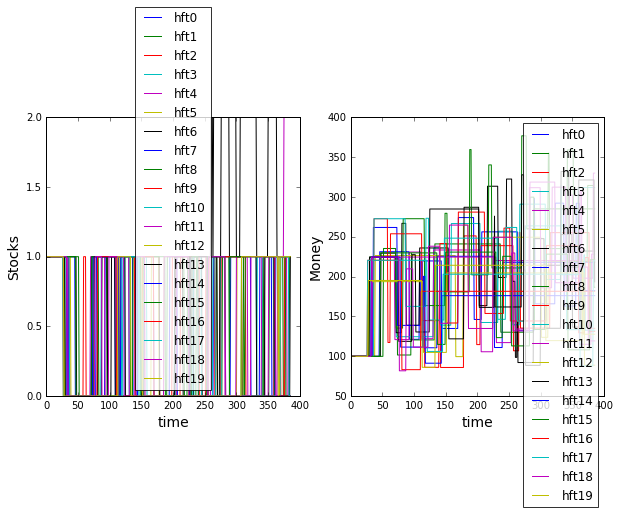

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

timeframe = 10000

for idx, s in enumerate(stocks):
    ax1.plot(range(len(s[:timeframe])), s[:timeframe], label='hft{}'.format(idx))

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Stocks', fontsize='14')
ax1.set_xlabel('time', fontsize='14')

for idx, m in enumerate(money):
    ax2.plot(range(len(m[:timeframe])), m[:timeframe], label='hft{}'.format(idx))

ax2.legend(frameon=True, loc='best', framealpha=0.8)
ax2.set_ylabel('Money', fontsize='14')
ax2.set_xlabel('time', fontsize='14')
#fig.savefig('auto_correlation_abs.png')

# Orderbook depth

size of ask book? Size of bids book?

In [24]:
np.random.normal(scale=parameters['std_LFT_price'])

0.004313224404561005

# Experiments variables of interest